# Import

In [47]:
import os
import json
import posixpath
import requests
from PIL import Image

import pandas as pd
import numpy as np

import pprint
import boto3
import sagemaker

# Set Up

## Global Parameters

In [48]:
# Define Region
region = "us-east-1"

# Define Bucket
bucket = "dsba-6190-final-team-project"
key_level_1 = "imgs"
key_level_2 = "test"

# Define Endpoint
endpoint_name = 'image-classification-drivers-endpoint'

## AWS Functions

In [49]:
# Establish Boto3 Session
boto_sess = boto3.session.Session(region_name=region)

# Invoke SageMaker Runtime Client
runtime = boto_sess.client(service_name='runtime.sagemaker')

# Invoke S3 Client
s3_client = boto_sess.client(service_name='s3')

# Invoke S3 Resource
s3_res = boto_sess.resource('s3')

# Import Test Images
The test images are located in the project S3 Bucket, under with the key prefix **imgs/test**.

## Generate List of Images
First, we create a list of all objects in the project bucket, under prefix **imgs/test**. 

In [50]:
s3_list_obj_param = {
    "Bucket" : bucket,
    "Prefix" : posixpath.join(key_level_1, key_level_2)
}

response = s3_client.list_objects_v2(**s3_list_obj_param)

The initial call returns a large amount of metadata we are not interested in. So we strip it down to just the contents of the the list. The contents still encapsulate a dictionary of file name and additional metadata. So we further strip this down to only extract the file names, aka, the value associated with the key.

We also add a filter to ensure all the contents we are collecting are JPG images.

In [51]:
# Extract Contents from Item Search Response
test_imgs_contents = response['Contents']

# Initialize List of Test Images
test_imgs_list = []

# Append Keys for Test Images
for item in test_imgs_contents:
    for key, value in item.items():
        if key == 'Key' and 'jpg' in value:
            test_imgs_list.append(value)
            
# Inspect initial images in list to ensure proper execution            
print(test_imgs_list[:5])

['imgs/test/img_1.jpg', 'imgs/test/img_10.jpg', 'imgs/test/img_100.jpg', 'imgs/test/img_1000.jpg', 'imgs/test/img_100000.jpg']


In [52]:
file_name = "img_test/test_image.jpg"
s3_res.Bucket(bucket).download_file(test_imgs_list[5], file_name)

In [53]:
with open(file_name, 'rb') as f:
    payload = f.read()
    payload = bytearray(payload)

In [54]:
try: 
    response = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                       ContentType='application/x-image', 
                                       Body=payload)
    result = response['Body'].read()
    result = json.loads(result)
    pprint.pprint(result)

except:
        print("Error Raised. Check status of endpoint.")

[0.00036428458406589925,
 0.0017996972892433405,
 0.0003498703008517623,
 0.92418372631073,
 0.0067366985604166985,
 0.0011239186860620975,
 0.04217714071273804,
 0.013772956095635891,
 0.009061269462108612,
 0.00043045292841270566]


# Test REST API
We want to test that our REST API is up and running. If we POST the REST API an image, we should recieve a JSON back, with a list of the probabilies of the image for each class.

First we define some of the variables.

In [55]:
host_url = "https://96gfw8ry96.execute-api.us-east-1.amazonaws.com"
page = "Test/predict"
headers = {
    "Content-Type": "image/jpg"
}

Inspect the Image

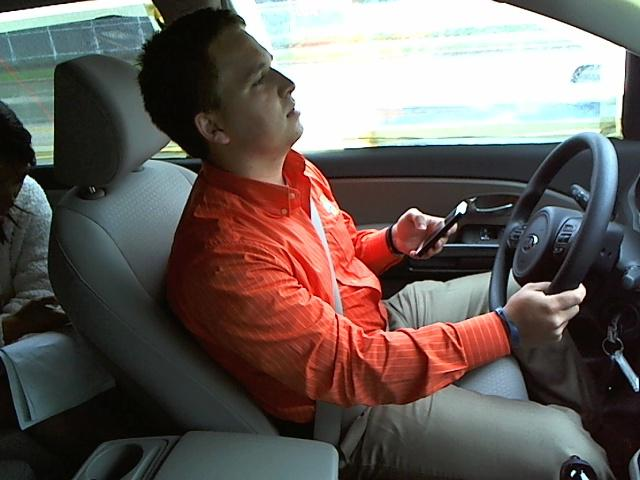

In [56]:
img = Image.open(file_name)
img

POST Inputs.

In [57]:
# Image to POST
data = open(file_name,'rb').read()

# POST Location
url = posixpath.join(host_url, page)

POST API

In [58]:
try:
    response = requests.post(url=url,
                             data=data, 
                             headers=headers)

    #Response Output
    result = json.loads(response.text)
    pprint.pprint(result)
    
except:
    print("Error Raised. Check status of REST API and SageMaker Endpoint.")

{'payload': [0.00036428458406589925,
             0.0017996972892433405,
             0.0003498703008517623,
             0.92418372631073,
             0.0067366985604166985,
             0.0011239186860620975,
             0.04217714071273804,
             0.013772956095635891,
             0.009061269462108612,
             0.00043045292841270566]}
